In [1]:
import numpy as np
import pandas as pd
import emcee
from multiprocessing import pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados
# =========================

# Cronômetros Cósmicos
df_cc = pd.read_csv("/home/brunowesley/projetos/MCMC-cosmo/Data/CC/CC_Hz_data.txt", sep=r"\s+")
z_cc   = df_cc["z_cc"].to_numpy(float)
H_obs  = df_cc["H_cc"].to_numpy(float)
H_err   = df_cc["H_cc_err"].to_numpy(float)

In [3]:
# ===================
# Fiducial
# ===================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6

# Parâmetros cosmológicos
Or0 = 7.88e-5

In [4]:
# =========================
# Funções cosmológicas
# =========================

def E_LCDM(z, Om0):
    Om = Om0 * (1 + z)**3
    Or = Or0 * (1 + z)**4
    Ol0 = 1 - Om0 - Or0
    return np.sqrt(Om + Or + Ol0)

def H_LCDM(z, H0, Om0):
    return H0 * E_LCDM(z, Om0)

print(H_LCDM(z_cc, 70, 0.3))

[ 72.32519073  73.03322223  74.1314077   76.05727142  76.41650152
  77.22840645  77.26949293  80.26045951  80.70603325  84.04613925
  85.41639663  86.39894212  86.41896391  87.6479917   88.93827653
  90.00503138  90.44605904  90.53673656  96.82219995 101.99455245
 106.35561345 106.35561345 108.34165726 109.57512132 114.56145767
 114.90041394 116.26425003 125.94082281 142.8571158  146.03393133
 151.12077405 156.63961932 165.07883266 184.45352498 204.39287936]


In [5]:
# =========================================
# Likelihood CC
# =========================================

# Priors
def lnprior_cc(theta_cc):
    H0, Om0 = theta_cc
    if not (H0_min <= H0 <= H0_max): return -np.inf
    if not (Om0_min <= Om0 <= Om0_max): return -np.inf
    return 0.0


# Likelihood
def lnlike_cc(theta_cc, z_cc, H_obs, H_err):
    H0, Om0 = theta_cc
    H_model = H_LCDM(z_cc, H0, Om0)
    chi2_cc = np.sum(((H_obs - H_model) / H_err)**2) 
    return -0.5 * chi2_cc


# Posteriori
def lnprob_cc(theta_cc, z_cc, H_obs, H_err):
    lp = lnprior_cc(theta_cc)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_cc(theta_cc, z_cc, H_obs, H_err)


# Teste rápido
print(lnprob_cc([70., 0.3], z_cc, H_obs, H_err))

-7.567754214643069


In [6]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 2, 40, 53500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme

# Paralelizando a criação das cadeias (MENOS eficiente para LCDM_CC)
# with mp.Pool(processes=40) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Criação das cadeias usando single-threaded (MAIS eficiente para LCDM_CC)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err))
sampler.run_mcmc(p0, nsteps, progress=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_LCDM_cc.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_LCDM_cc.npy", flat_samples)

100%|██████████| 53500/53500 [00:29<00:00, 1800.07it/s]


Removed no burn in


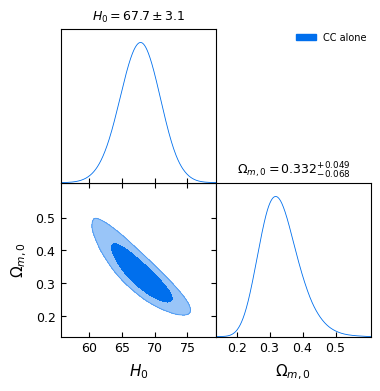

In [7]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0"]
param_labels = [r"H_0", r"\Omega_{m,0}"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["CC alone"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_LCDM_cc.png", dpi=300, bbox_inches="tight")
plt.show()